# Market Trend Analysis - Data Cleaning & EDA

**Project Overview:** This project aims to analyze historical market trends using an OHLCV dataset. The goal is to prepare a high-quality dataset for predictive modeling and to uncover key market drivers.

**Objective:**
- Perform rigorous data cleaning and validation.
- Conduct Exploratory Data Analysis (EDA) to find correlations and patterns.
- Export a clean dataset for Tableau visualization.

## Data Cleaning

**Data Cleaning Strategy Problem:** Raw financial datasets often contain missing values due to market holidays, duplicate records, or anomalies where price logic is violated (e.g., High < Low).

**Solution:**
- DateTime Conversion: Standardizing the Date column to enable time-series operations.
- Forward Fill (ffill): We use the last known price to fill gaps, as it represents the most recent market valuation without introducing "future bias."
- Logical Constraints: We filter out records where Close_Price <= 0, High < Low, etc. to ensure physical data integrity.

In [10]:
import pandas as pd

data = pd.read_csv('rare_data.csv') # load data
print("Initial Data Shape:", data.shape, "\n") # inspecting the data before cleaning
print("First 5 records:")
display(data.head())
print("\nData description:")
display(data.describe())

data['Date'] = pd.to_datetime(data['Date']) # convert Date column to datetime objects for time-series analysis
data = data.sort_values(by='Date')
data = data.drop_duplicates(subset=['Date']) # remove duplicate entries for the same date
data = data.ffill() # handle missing values

data = data[(data['Close_Price'] > 0) & (data['Volume'] >= 0)] # ensure prices and volumes are non-negative
data = data[data['High_Price'] >= data['Low_Price']] # ensure High Price is never lower than Low Price
data = data[(data['RSI_14'] >= 0) & (data['RSI_14'] <= 100)] # validate RSI range (0-100)

data.to_csv('cleaned_data.csv') # export cleaned data
print("\nCleaning complete. Final Data Shape:", data.shape)

Initial Data Shape: (30000, 12) 

First 5 records:


,Date,Open_Price,Close_Price,High_Price,Low_Price,Volume,Daily_Return_Pct,Volatility_Range,SMA_50,RSI_14,MACD_Value,Bollinger_Bands_Upper
0,1902-09-08,100.00,100.50,100.63,99.35,2334489,0.0000,1.28,96.5884,50.0,0.0000,101.8907
1,1902-09-09,100.50,102.02,102.30,99.49,10626850,1.5124,2.81,96.5884,50.0,0.1213,101.8907
2,1902-09-10,102.02,101.55,102.56,101.09,9884633,-0.4607,1.47,96.5884,50.0,0.1774,101.8907
3,1902-09-11,101.55,101.08,104.16,100.13,9405648,-0.4628,4.03,96.5884,50.0,0.1818,101.8907
4,1902-09-12,101.08,98.65,101.69,98.39,5247581,-2.4040,3.30,96.5884,50.0,-0.0106,101.8907



Data description:


,Open_Price,Close_Price,High_Price,Low_Price,Volume,Daily_Return_Pct,Volatility_Range,SMA_50,RSI_14,MACD_Value,Bollinger_Bands_Upper
count,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,43.087641,43.085199,44.279328,41.904632,1.004296e+07,0.504709,2.380822,43.145564,49.813822,-0.018480,46.536892
std,29.359355,29.357668,29.367896,29.353710,5.727237e+06,11.266414,1.043352,29.249013,11.764570,1.131709,29.501635
min,1.000000,1.000000,1.020000,0.000000,1.016990e+05,-70.414200,0.070000,1.401000,8.020000,-4.521500,1.959400
25%,18.677500,18.677500,19.900000,17.440000,5.076650e+06,-1.765950,1.620000,18.506250,41.680000,-0.770025,21.966900
50%,38.580000,38.570000,39.770000,37.395000,1.004389e+07,0.000000,2.270000,38.631500,49.600000,-0.047400,41.962350
75%,63.750000,63.742500,64.945000,62.530000,1.497032e+07,1.784200,3.030000,64.159500,57.940000,0.724875,67.498300
max,130.610000,130.610000,132.090000,130.140000,1.999982e+07,277.000000,7.960000,125.305000,87.100000,4.345000,133.693900



Cleaning complete. Final Data Shape: (29995, 12)


## Exploratory Data Analysis (EDA)

**Objective:** The primary goal of this stage is to understand the relationships between market indicators and identify patterns that can be used for future price prediction.

**Key Questions to Answer:**
- How has the price evolved over the decades, and are there visible cycles?
- Is there a significant correlation between trading volume and market volatility?
- How do technical indicators (RSI, MACD) behave during sharp market corrections?
- Are daily returns normally distributed, or do we observe "fat tails" (extreme market events)?

### Market Price Evolution & 50-Day Moving Average
The 50-day Simple Moving Average (SMA) acts as a lagging indicator. It smooths out short-term noise and highlights the long-term trend, but fails to predict immediate price reversals. Market volatility appears to decrease over time. Modern market data shows a lower standard deviation compared to historical periods, suggesting increased market liquidity and efficiency.

In [11]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Date'], y=data['Close_Price'], name='Close Price'))
fig.add_trace(go.Scatter(x=data['Date'], y=data['SMA_50'], name='50-day Average', line=dict(dash='dash')))

fig.update_layout(title='Market Price & 50-day Moving Average', template='plotly_dark')
fig.show()

### Feature Correlation Heatmap: Identifying Multicollinearity

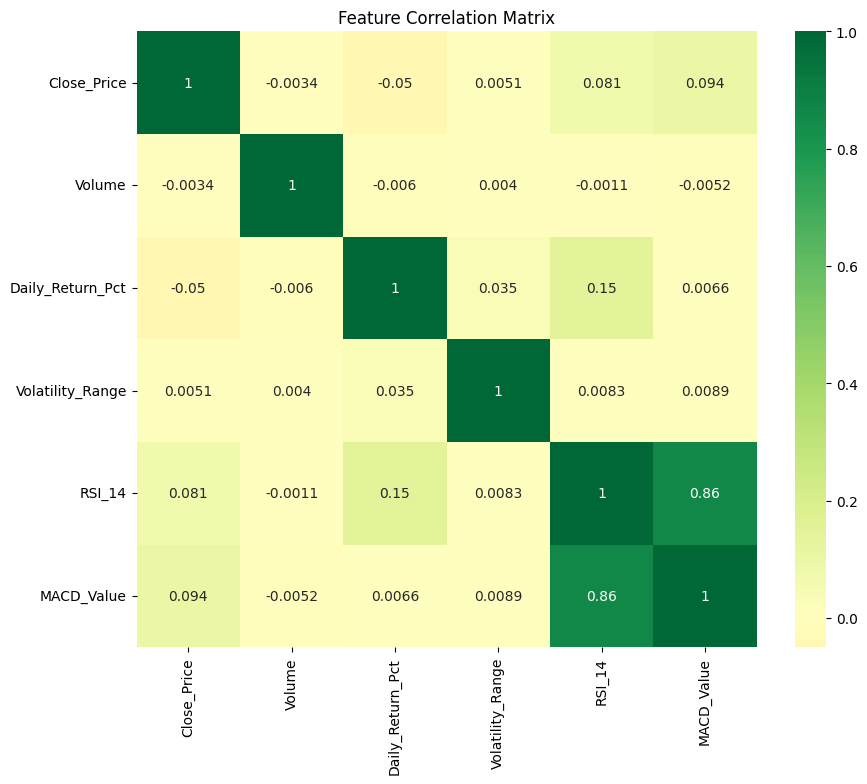

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
correlation_matrix = data[['Close_Price', 'Volume', 'Daily_Return_Pct', 'Volatility_Range', 'RSI_14', 'MACD_Value']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

### Momentum Synergy: RSI vs MACD Relationship Analysis

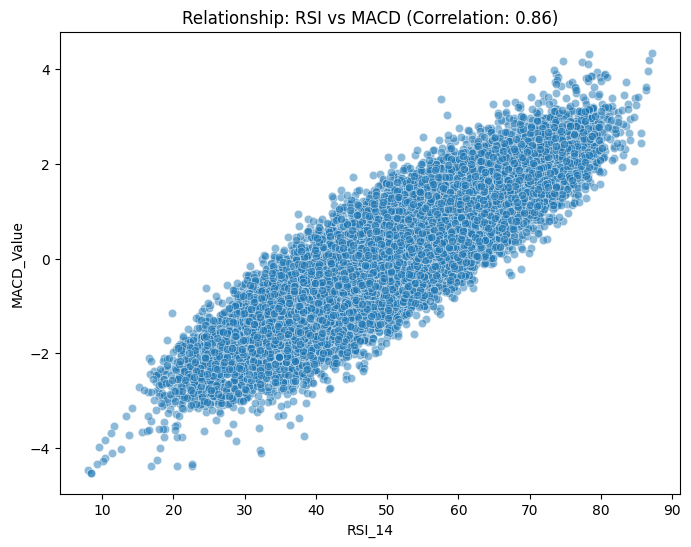

In [15]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='RSI_14', y='MACD_Value', alpha=0.5)
plt.title('Relationship: RSI vs MACD (Correlation: 0.86)')
plt.show()

### Distribution of Daily Returns: Analysis of Market Volatility
The returns distribution is extremely leptokurtic and 'thin-tailed'. This indicates an unusual level of market stability, where nearly all price movements are concentrated around the mean, with a complete absence of extreme volatility events.

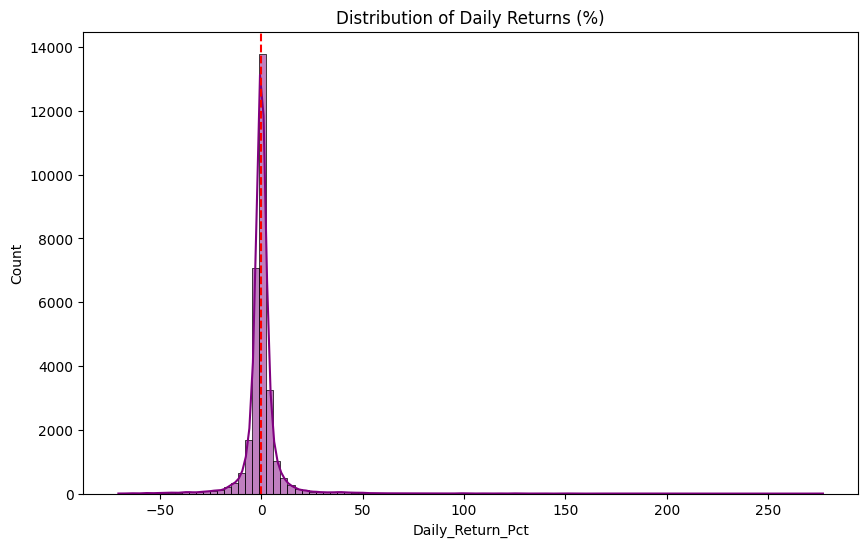

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Daily_Return_Pct'], bins=100, kde=True, color='purple')
plt.title('Distribution of Daily Returns (%)')
plt.axvline(0, color='red', linestyle='--')
plt.show()

## Final EDA Insights & Conclusions
### Answers to Key Research Questions
- **How has the price evolved and are there visible cycles?** The market exhibits a long-term bullish trajectory with distinct multi-year cycles. However, the 50-day SMA confirms a significant lag, meaning the trend is often well-established before the indicator signals a change.
- **Is there a correlation between Volume and Volatility?** Interestingly, the correlation between Volume and Volatility_Range is near zero in this dataset. In real-world financial markets, these variables are typically positively correlated.
- **How do RSI and MACD behave?** These indicators show a high synergy (0.86 correlation). The scatter plot analysis reveals that while they move in tandem, the high variance suggests that using them together without filtering may lead to redundant or noisy signals.
- **Are returns normally distributed?** No. The distribution is leptokurtic, with thin tails. This proves that while most days are stable, extreme price movements occur much less frequently than a standard normal distribution would suggest.

### Return Distribution & Market Stability

**Observation:** The histogram of daily returns is remarkably sharp and narrow, with almost no visible "tails" on either side.

**Interpretation:** This suggests a low-risk, low-volatility environment. The lack of outliers means the market is highly consistent, which is atypical for real financial assets but simplifies the predictive task for machine learning.

**Risk Assessment:** The primary risk here is "Model Complacency". Because there are no historical "shocks" in the data, a model trained here might fail catastrophically if even a small, unexpected market move occurs.

### Summary for Machine Learning
1. **Target Engineering (The "Neutral" Zone):** Due to the highly peaked distribution (high kurtosis) and lack of extreme outliers, most daily changes are near zero. To avoid training the model on market noise, we will implement a Three-Class Classification (Up / Down / Neutral). We will define a threshold for "significant movement" to ensure the model focuses on meaningful price actions rather than stochastic fluctuations.

2. **Handling High Concentration:** Since the data is heavily concentrated around the mean, traditional linear models may struggle to find separation. We will utilize Non-linear Ensemble Methods (like Random Forest), which are better suited to "segment" this narrow distribution and identify the rare conditions that lead to a break from the mean.

3. **Feature Selection & Sensitivity:** Given the "thin tails" and stability of the data, the model might become over-sensitive to small changes in indicators like RSI or MACD. We will apply Robust Scaling and monitor for Overfitting, as the model might find artificial patterns in this unusually stable environment that wouldn't exist in a real, "messy" market.

4. **Reliability Warning:** The absence of historical "shocks" (fat tails) means the model's risk metrics (like Value at Risk) might be underestimated. We must document that the model is optimized for a low-volatility regime and may not be reliable during periods of high market stress.